<a href="https://colab.research.google.com/github/Leman5/ColabFiles/blob/main/Collaborative_Filtering_Imp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaboative Filtering Method ( Anime Recommendation System)

Methods Implemented
A. Memory Based (User Based and Item Based Collaborative Filtering)

Load Data and Preprocess Step


In [5]:
# Package imports
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
file_path = '/content/drive/My Drive/Anime Recommender System/Datasets/' # Generic file path
anime_rating_file_path = file_path + 'user-filtered.csv' # File path of the anime ratings along with user IDs
anime_data_file_path = file_path + 'anime-filtered.csv' # File path of the anime data
user_details_file_path = file_path + 'users-details-2023.csv' # File path of user details data
ratings_df = pd.read_csv(anime_rating_file_path) # Create dataframe of anime ratings

anime_df = pd.read_csv(anime_data_file_path)  # Create dataframe of anime

user_df = pd.read_csv(user_details_file_path) # Create dataframe for user details

In [8]:
# Show some rows in rating dataframe
print(ratings_df.head(5))

   user_id  anime_id  rating
0        0        67       9
1        0      6702       7
2        0       242      10
3        0      4898       0
4        0        21      10


In [9]:
print(user_df.head(5))

   Mal ID Username  Gender                   Birthday              Location  \
0       1    Xinil    Male  1985-03-04T00:00:00+00:00            California   
1       3  Aokaado    Male                        NaN          Oslo, Norway   
2       4  Crystal  Female                        NaN  Melbourne, Australia   
3       9   Arcane     NaN                        NaN                   NaN   
4      18      Mad     NaN                        NaN                   NaN   

                      Joined  Days Watched  Mean Score  Watching  Completed  \
0  2004-11-05T00:00:00+00:00         142.3        7.37       1.0      233.0   
1  2004-11-11T00:00:00+00:00          68.6        7.34      23.0      137.0   
2  2004-11-13T00:00:00+00:00         212.8        6.68      16.0      636.0   
3  2004-12-05T00:00:00+00:00          30.0        7.71       5.0       54.0   
4  2005-01-03T00:00:00+00:00          52.0        6.27       1.0      114.0   

   On Hold  Dropped  Plan to Watch  Total Entries 

In [10]:
# Show some rows in anime dataframe
print(anime_df.head(3))

   anime_id                             Name  Score  \
0         1                     Cowboy Bebop   8.78   
1         5  Cowboy Bebop: Tengoku no Tobira   8.39   
2         6                           Trigun   8.24   

                                              Genres            English name  \
0    Action, Adventure, Comedy, Drama, Sci-Fi, Space            Cowboy Bebop   
1              Action, Drama, Mystery, Sci-Fi, Space  Cowboy Bebop:The Movie   
2  Action, Sci-Fi, Adventure, Comedy, Drama, Shounen                  Trigun   

    Japanese name                                          sypnopsis   Type  \
0       カウボーイビバップ  In the year 2071, humanity has colonized sever...     TV   
1  カウボーイビバップ 天国の扉  other day, another bounty—such is the life of ...  Movie   
2           トライガン  Vash the Stampede is the man with a $$60,000,0...     TV   

  Episodes                        Aired  ...         Duration  \
0       26  Apr 3, 1998 to Apr 24, 1999  ...  24 min. per ep.   
1        1 

In [11]:
'''
Filter the ratings dataframe by taking values of users having users that have completed watching 50 0r more animes. Also, we consider userIDs less than 30,000
We take the subset of the data. We could not take location because very few users have location values and some of them have inconsistencies.
'''

user_df = user_df[(user_df['Completed'] >= 50) & (user_df['Mal ID'] <= 2000)] # changed to 3000 as it took long for running
selected_user_ids = user_df['Mal ID'] # Get the selected user details
# Filter the ratings based on user IDs and rating values range 0 to 10
filtered_rating_df = ratings_df[(ratings_df['user_id'].isin(selected_user_ids)) & (ratings_df['rating'] >= 0) &  (ratings_df['rating'] <= 10) ]

# Calculating the total number of ratings per user
user_total_rating = filtered_rating_df['user_id'].value_counts()

# Filtering users who have rated at least 50 animes
filter_user_ids = user_total_rating[user_total_rating >= 50].index

# Filter the anime ratings where user has at least 50 ratings provided
filtered_rating_df = filtered_rating_df[filtered_rating_df['user_id'].isin(filter_user_ids)]

# Counting total number of rows in filtered_rating_df
total_rows = filtered_rating_df.shape[0]

# Display the filtered DataFrame and the total number of rows
print(filtered_rating_df)
print("Total number of rows:", total_rows)

        user_id  anime_id  rating
74            1     37403       8
75            1      9989       0
76            1     24833       0
77            1      7674       7
78            1     34572       0
...         ...       ...     ...
600356     2000     11757       4
600357     2000      3457       4
600358     2000     38408       0
600359     2000     35972       0
600360     2000     34134       0

[202556 rows x 3 columns]
Total number of rows: 202556


In [12]:
# Preprocess the data
filtered_rating_df = filtered_rating_df.drop_duplicates(subset=['user_id', 'anime_id']) # Drop duplicate values
filtered_rating_df = filtered_rating_df.dropna() # Drop missing values
filtered_rating_df['rating'] = filtered_rating_df['rating'].astype(float) # Converting type of ratings to float

In [13]:
filtered_rating_df.head(4)

,user_id,anime_id,rating
74,1,37403,8.0
75,1,9989,0.0
76,1,24833,0.0
77,1,7674,7.0


In [14]:
print(filtered_rating_df.isnull().sum()) # Checking missing values in dataframe
print(filtered_rating_df.duplicated().sum()) # Checking missing values in dataframe
print(filtered_rating_df.info()) # Print data frame summary

user_id     0
anime_id    0
rating      0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 202556 entries, 74 to 600360
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   202556 non-null  int64  
 1   anime_id  202556 non-null  int64  
 2   rating    202556 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 6.2 MB
None


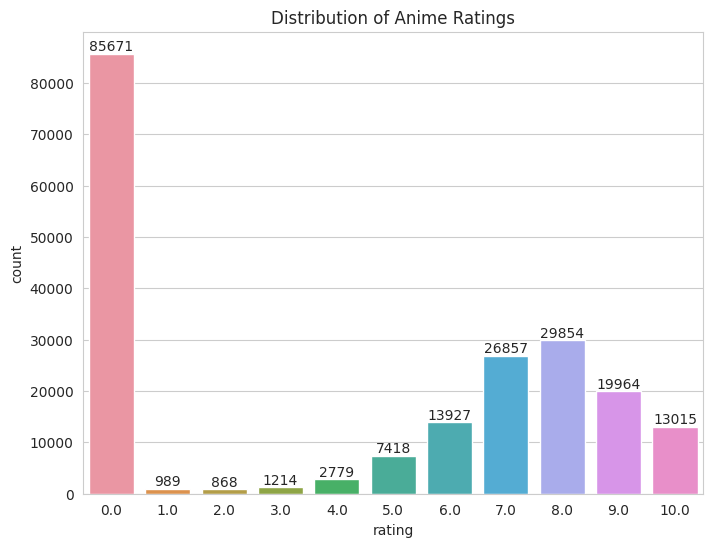

In [15]:
# Plot the distribution of ratings

sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
# Calculating count of the rating
rating_counts = filtered_rating_df['rating'].value_counts().sort_index()

# Creating a countplot with frequency of the left
sns.countplot(x='rating', data=filtered_rating_df, order=rating_counts.index)

# Adding counts on top of bar
for i, count in enumerate(rating_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Distribution of Anime Ratings')
plt.show()

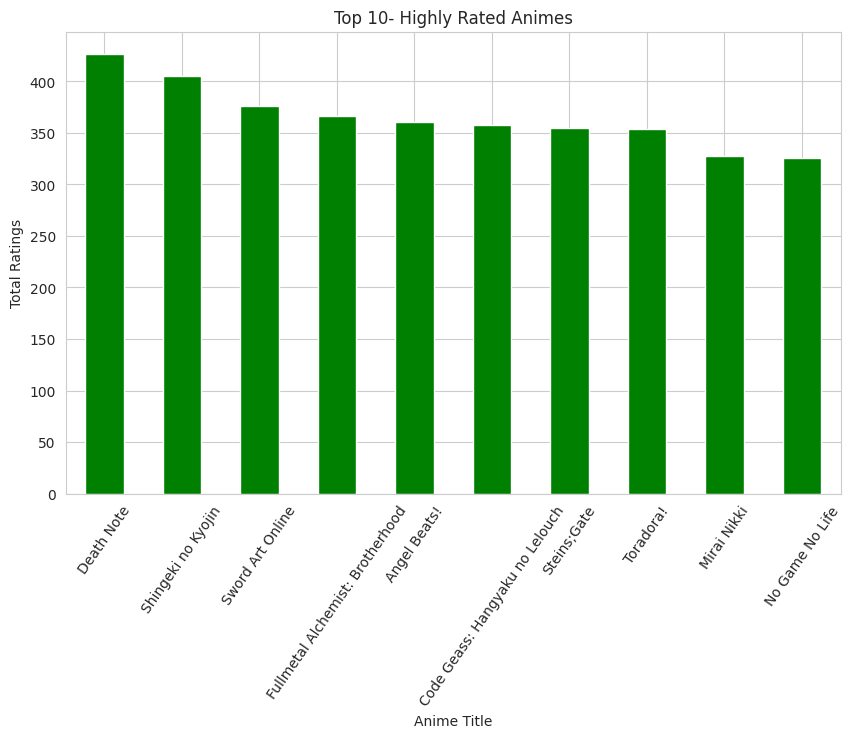

In [16]:
selected_anime_columns = anime_df[['anime_id', 'Name', 'Score', 'Genres', 'Type', 'Episodes']] # View selected columns of the anime dataframe
# Merge two dataframes based on 'anime_id' column value
merged_df = filtered_rating_df.merge(anime_df[['anime_id', 'Name', 'Genres']], how='left', on='anime_id')


# Highly rated animes (top 10 animes with more number ofa ratings)
highly_rated_movies = merged_df['Name'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
highly_rated_movies.plot(kind='bar', color = 'green')
plt.xlabel('Anime Title')
plt.ylabel('Total Ratings')
plt.title('Top 10- Highly Rated Animes')
plt.xticks(rotation=55)
plt.show()

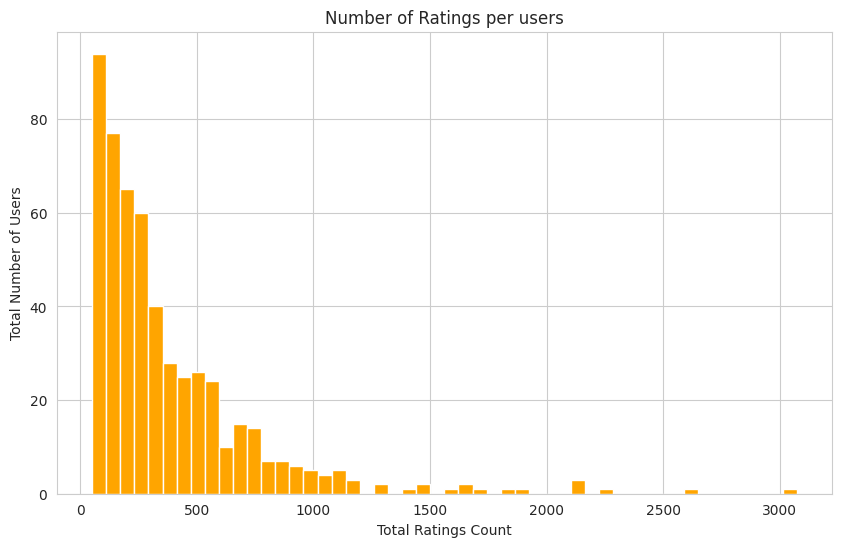

In [17]:
# Show number of ratings per given user
ratings_by_user = filtered_rating_df['user_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(ratings_by_user, bins=50, edgecolor='white', color='orange')
plt.xlabel('Total Ratings Count')
plt.ylabel('Total Number of Users')
plt.title('Number of Ratings per users')
plt.show()



# A. Memory Based - User Based Collaborative Filtering

User Based Collaborative Filtering is implemented as follows below:
1. First of all the anime ratings dataframe is peformed train-test split using stratified sampling over user_id such that we have similar distribution in both train and test set.
2. We have used train dataset in order to build the user-anime matrix and also find the cosine similarity between users.
3. The values in the test dataset will be used to predict the rating of the anime. By comparing the actual rating and predicted ratings, we have computed Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) for the evaluation.
4. Likewise, we have shown the top-N recommendations to particular user based on top predicted ratings by the model built.
5. For the evaluation of top-N recommendations, we have used precision@N, recall@N, f1-score@N and average precision@N for single users. For evaluating for all the users, we have used mean average precision @N which is the average precision@N over all the users.
For the evaluation, we have used test dataset in the following way. We give top N recommendations using the train dataset for the user and we use the test dataset in order to determine whether the recommendation was relevant or not. We consider a rating threshold, if the anime recommended is rated by the same user in test dataset and the rating is equal or above the rating threshold, we consider it to be relevant recommendation. Likewise, we have evaluated Mean Average Precision@N over various rating threshold values.

In [24]:

y = filtered_rating_df['user_id'].tolist() # Set the user_ids value to generate stratified sampling below

# Split the dataset into a train set and a test set along with stratified split along user_id
train_df, test_df = train_test_split(filtered_rating_df, test_size=0.2, random_state=42, stratify=y)

print("Train/test split of the dataset")
print()
print(f"Train Dataset: Showing 20 values from head \n\n {train_df.head(20)}")
print()
print("***********************************************")
print()
print(f"Test Dataset: Showing 20 values from head \n\n {test_df.head(20)}")
print()
print("***********************************************")
print()
print("Total Rows in train_df:", train_df.shape[0])
print("Total Rows test_df:", test_df.shape[0])

Train/test split of the dataset

Train Dataset: Showing 20 values from head 

         user_id  anime_id  rating
344762     1079     19815    10.0
31876       120     22961     9.0
105613      357     32937     9.0
554745     1839     34134     0.0
582863     1941     40239     0.0
483850     1570       736     7.0
203622      683     34626     0.0
145095      478      2311     1.0
387383     1245     30727     8.0
102650      346     27775     0.0
123727      425       814     8.0
362719     1162     34498     6.0
478608     1554     32899     8.0
203213      683     37362     8.0
522130     1700      1538     0.0
96731       327     34447     7.0
117239      399       522     7.0
214226      720     40454     8.0
285238      906       981    10.0
428235     1393     40254     5.0

***********************************************

Test Dataset: Showing 20 values from head 

         user_id  anime_id  rating
345746     1085       636     0.0
112081      376     34392     6.0
456029    

# Helper Functions Definition
All the functions needed in the code below for implementation are defined here

In [25]:
# Function to create user-anime matrix
def create_user_anime_matrix(train_df):
    """
    Using pandas-pivot function to create user-anime matrix
    Rows represent users, columns represent anime ids and values represent ratings
    """
    user_anime_matrix = train_df.pivot(index='user_id', columns='anime_id', values='rating')
    return user_anime_matrix

# Function to normalize user-anime matrix as ratings can have huge variation
def normalize_user_anime_matrix(user_anime_matrix):

    user_anime_matrix = user_anime_matrix.fillna(0) # Fill empty ratings with 0

   # Calculate average rating for each user considering mean of all the ratings
    user_rating_mean = user_anime_matrix.mean(axis = 1)

    # Subtracting value with row mean and normalizing the matrix
    user_anime_matrix_norm = user_anime_matrix.sub(user_rating_mean, axis = 0)

    return user_anime_matrix_norm

# Function to calculate similarity between users using cosine similarity
def calculate_user_similarity(user_anime_matrix_norm):

    # Calculate similarity using cosine similarity
    user_similarity = cosine_similarity(user_anime_matrix_norm)

    return user_similarity


"""
Function to normalize cosine similarity between users
Those normalized similarities will be used as weight while calculating the anime weighted scores for recommendation
"""
def normalize_user_similarity(user_similarity):
    min_cosine_value = user_similarity.min() # Evaluate min value
    max_cosine_value = user_similarity.max() # Calculate max value

    # Normalize the similarity values between users
    normalized_user_similarity = (user_similarity - min_cosine_value) / (max_cosine_value - min_cosine_value)

    return normalized_user_similarity


"""
Function to create dataframe from normalized user similarity values.
The normalized user similarity that is numpy array will be converted to dataframe mapping user_ids.
The mappings will be used to find the similarity values of particular user (provided the user_id) with other users.
user_ids in argument is used to pass all the users such that we map respective similarity values.
"""
def create_df_norm_user_similarity(normalized_user_similarity, user_ids):

    # Create dataframe from numpy array of normalized user similarity
    cosine_weights_df =  pd.DataFrame(normalized_user_similarity)

    cosine_weights_df.index = user_ids # Set row labels of dataframe
    cosine_weights_df.columns = user_ids # Set column labels of dataframe

    return cosine_weights_df


"""
Function to calculate top N similar users for given user with user_id.
top_N_similary argument sets the number of similar users returned for the particular user.
similarity_threshold sets the value and we filter users having similarities more than threshold value.
"""
def find_similar_users(cosine_similarity_df, selected_user_id,
                       top_N_similar, similarity_threshold):

    # Find the user similarity from the cosine similarity dataframe
    selected_user_similarity = cosine_similarity_df.loc[selected_user_id]

    # Remove the selected_useer_id from calculation as it similarity with itself will be 1
    selected_user_similarity = selected_user_similarity.drop(selected_user_id)

    # Sort the similarity scores in descending order
    sorted_similarity = selected_user_similarity.sort_values(ascending=False)

    # Filter the similar users based on similarity_threshold value
    selected_similar_users = sorted_similarity[sorted_similarity >= similarity_threshold]

    # Select top N similar users
    top_N_similar_users = selected_similar_users.head(top_N_similar)


    return top_N_similar_users


# Function to calculate already watched animes by given user (user_id)
def already_watched_animes(train_df, selected_user_id):
    # Pick animes that the selected user has already watched
    watched_animes = train_df[train_df['user_id'] == selected_user_id]['anime_id'].tolist()

    watched_animes = list(set(watched_animes)) # Set unique anime ids

    return watched_animes

# Function to calculate animes watched by similar users
def similar_users_watched_animes(train_df, similar_user_ids):
    # Find animes watched by similar users
    similar_users_animes = train_df[train_df['user_id'].isin(similar_user_ids)]['anime_id'].tolist()

    similar_users_animes = list(set(similar_users_animes)) # Calculate unique anime ids

    return similar_users_animes

"""
Function to filter user_anime matrix by removing anime_ids such as anime_ids that selected user has
already watched is removed from the column. Likewise, the anime_ids that the similar users have watched are
kept, others are removed from columns for the calculation for particular selected user.
"""
def filter_user_anime_matrix(user_anime_matrix, user_watched_anime_ids,
                             similar_users_watched_anime_ids, similar_user_ids):

    # Removing the animes watched by the user
    user_anime_matrix_filtered = user_anime_matrix.drop(columns=user_watched_anime_ids, axis=1)

    # Keeping only similar users in the filtered matrix
    user_anime_matrix_filtered_sim = user_anime_matrix_filtered.loc[similar_user_ids]

    # Keeping only animes that the similar users have watched
    user_anime_matrix_filtered_sim = user_anime_matrix_filtered_sim[similar_users_watched_anime_ids]

    return user_anime_matrix_filtered_sim


In [26]:
"""
Function to find Precision@N, Recall@N and F1-Score@N for particular user
The test dataframe is used to find out whether the recommendations in top N are relevant or not
rating_threshold value is passed such that we consider if the user has rated >= rating_threshold and the
anime is recommended, it falls into relevant recommended anime in the list.
"""
def evaluate_metrics_user(test_df, selected_user_id, rating_threshold, top_N_recommendations):

    # Finds all the animes above the rating_threshold from test dataframe considering the user liked those animes
    all_relevant_animes = test_df[(test_df['user_id'] == selected_user_id)
                                  & (test_df['rating'] >= rating_threshold)]['anime_id'].values

    total_recommendations = len(top_N_recommendations) # Total recommendations

    # Find relevant recommendations in top_N list
    relevant_recommendations = set(top_N_recommendations).intersection(all_relevant_animes)

    # Calculate precision@N
    if total_recommendations == 0 or len(relevant_recommendations) == 0:
        precision_at_N = 0
    else:
        precision_at_N = len(relevant_recommendations) / total_recommendations


    # Calculate Recall@N
    if total_recommendations == 0 or len(relevant_recommendations) == 0:
        recall_at_N = 0
    else:
        recall_at_N = len(all_relevant_animes) / len(relevant_recommendations)


    # Calculate F1-score@N
    if (precision_at_N + recall_at_N) == 0:
        f1_score_at_N = 0
    else:
        f1_score_at_N = 2 * (precision_at_N * recall_at_N) / (precision_at_N + recall_at_N)


    return precision_at_N, recall_at_N, f1_score_at_N


"""
Function to evaluate Average Precision@N
The Average Precision@K or AP@K is the sum of precision@K where the item at the kₜₕ rank is
relevant (rel(k)) divided by the total number of relevant items (r) in the top K recommendations
"""
def evaluate_average_precision_at_N(test_df, selected_user_id,
                                    rating_threshold, top_N_recommendations):
     # Finds all the animes above the rating_threshold from test dataframe considering the user liked those animes
    all_relevant_animes = test_df[(test_df['user_id'] == selected_user_id)
                                  & (test_df['rating'] >= rating_threshold)]['anime_id'].values

    total_recommendations = len(top_N_recommendations) # Total recommendations

    # Find relevant recommendations in top_N list
    relevant_recommendations = set(top_N_recommendations).intersection(all_relevant_animes)

    total_relevant_recommendations = len(relevant_recommendations) # Set the total number of relevant recommendations
    total_precision = 0 # Set the total precision value to 0
    relevant_anime_at_k = 0 # Set the number of relevant animes up to kth position

    for i in range(len(top_N_recommendations)):
        anime_rank = i + 1 # Set rank of anime as the loop starts from 0 index 1 is added

        if top_N_recommendations[i] in relevant_recommendations:
            relevant_anime_at_k += 1 # Relevant anime found, so increment count
            total_precision += relevant_anime_at_k / anime_rank

    if total_relevant_recommendations == 0:
        return 0 # If there are no relevant recommendations

    average_precision_at_N =  total_precision / total_relevant_recommendations

    return average_precision_at_N


In [27]:
# Function to calculate weighted anime predicted rating
def calculate_anime_predicted_ratings(test_anime_id, selected_user_id):
    if test_anime_id in user_anime_matrix:

        users_anime_ratings = user_anime_matrix[test_anime_id]  # Filter user ratings in given anime_id

        # Get the index of animes that are not rate by users i.e. having NaN values
        not_rated_anime_index = users_anime_ratings[users_anime_ratings.isna()].index

        # Drop the values in that consists of NaN values
        users_anime_ratings = users_anime_ratings.dropna()

        # Get cosine similarity weights of particular user ID with other users
        cosine_weights = cosine_weights_df[selected_user_id]

        # Remove the users from the similarity values that did not rate the given anime (test_anime_id
        filtered_cosine_weights = cosine_weights.drop(not_rated_anime_index)

        # Sort the similarity scores in descending order
        sorted_cosine_weights = filtered_cosine_weights.sort_values(ascending=False)



        # Using the top similar users value
        top_similar_cosine_weights = sorted_cosine_weights[:top_N_similar_users]

        # Aligning the index of anime ratings and cosine similarity weights in same order
        # as it order was modified when sorting the cosine weights
        users_anime_ratings_fix_index = users_anime_ratings.reindex(top_similar_cosine_weights.index)

        # Calculate the predicted rating of anime using weighted cosine similarity, adding small value to avoid zero division
        predicted_anime_rating = np.dot(users_anime_ratings_fix_index, top_similar_cosine_weights) / (top_similar_cosine_weights.sum() + 1e-6)


        return round(predicted_anime_rating, 2)

    else:
        return 5 # Return mid value of rating range if anime values not present in training set


In [28]:
# Function to get top N recommendations for selected User ID
def get_top_N_recommendations_cf(selected_user_id, printResult=None):

    # Get cosine similarity weights of particular user ID with other users
    cosine_weights = cosine_weights_df[selected_user_id]

    # Remove own selected user cosine weights
    filtered_cosine_weights = cosine_weights.drop(selected_user_id)

    # Sort the cosine weights
    sorted_cosine_weights = filtered_cosine_weights.sort_values(ascending=False)

    # Get top N similar users
    top_similar_users = sorted_cosine_weights[:top_N_similar_users]


    # Find already watched animes by selected user
    user_watched_anime_ids = already_watched_animes(train_df, selected_user_id)

    similar_user_ids = top_similar_users.index.tolist() # Get similar user IDs

    # Find watched animes by similar users
    similar_users_watched_anime_ids = similar_users_watched_animes(train_df,similar_user_ids )

    # Filter the anime IDs watched by similar users that is not watched by selected user_id
    filtered_sim_users_watched_anime_ids = list(set(similar_users_watched_anime_ids) - set(user_watched_anime_ids))


    anime_predicted_ratings = {} # Create a dictionary to store anime_ids and predicted ratings

    # Loop through the anime_ids to get predicted ratings
    for anime_id in filtered_sim_users_watched_anime_ids:
        predicted_rating = calculate_anime_predicted_ratings(anime_id, selected_user_id)
        anime_predicted_ratings[anime_id] = predicted_rating

    # Sort the dictionary by predicted ratings in descending order
    sorted_anime_ratings = dict(sorted(anime_predicted_ratings.items(), key=lambda item: item[1], reverse=True))

    # Get the top N recommendations
    top_N_recommendations = list(sorted_anime_ratings.keys())[:top_N_value]

    # If printResult value set, display the result
    if printResult:
        print(f"Top-{top_N_value} Anime Recommendations for User ID: {selected_user_id}")

        # Loop through the top N to print anime with anime details
        for anime_id in top_N_recommendations:

            # Finding  the row in anime dataframe matching given anime ID
            anime_info = anime_df[anime_df['anime_id'] == anime_id]
            print(f"Anime ID: {anime_id}, Name: {anime_info['Name'].values[0]}, Genre: {anime_info['Genres'].values[0]}" )

    return top_N_recommendations


# Function to evaluate Root Mean Squared Error (RMSE) of the recommender system
def evaluate_memory_based_CF(test_df):

    # Pair user_id and anime_id from the test dataframe
    anime_user_pairs = zip(test_df['anime_id'], test_df['user_id'])

    # Empty numpy array to store predicted ratings
    predicted_ratings = np.array([])

    # Loop through user and anime pairs to find the predicted rating
    for anime_id, user_id in anime_user_pairs:
        predicted_rating = calculate_anime_predicted_ratings(anime_id, user_id)
        predicted_ratings = np.append(predicted_ratings, predicted_rating)

    # Get the true ratings of anime
    true_ratings = np.array(test_df['rating'])

    # Calculate mean squared error
    mse = np.square(np.subtract(true_ratings,predicted_ratings)).mean()

    # Calculate root mean squared error
    rmse = np.sqrt(mse)

    # Calculate mean absolute error
    mae = mean_absolute_error(true_ratings, predicted_ratings)

    return rmse, mae

In [29]:
# Build user anime matrix
user_anime_matrix = create_user_anime_matrix(train_df)
print(f"User-Anime Matrix: \n \n {user_anime_matrix}")

User-Anime Matrix: 
 
 anime_id  1      5      6      7      8      15     16     17     18     \
user_id                                                                   
1           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3           9.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    8.0   
4           NaN    NaN    NaN    NaN    NaN    NaN    9.0    NaN    NaN   
18          8.0   10.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
20          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
1989        NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1990        NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1994        NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1999        NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2000        NaN    NaN    NaN    NaN    NaN    9.0    NaN    NaN    9.0   

a

In [30]:
# Normalize user anime matrix
user_anime_matrix_norm = normalize_user_anime_matrix(user_anime_matrix)
print(f"User-Anime Matrix (Normalized) : \n \n {user_anime_matrix_norm}")

User-Anime Matrix (Normalized) : 
 
 anime_id     1         5         6         7         8         15     \
user_id                                                                
1        -0.075966 -0.075966 -0.075966 -0.075966 -0.075966 -0.075966   
3         8.801204 -0.198796 -0.198796 -0.198796 -0.198796 -0.198796   
4        -0.075263 -0.075263 -0.075263 -0.075263 -0.075263 -0.075263   
18        7.948721  9.948721 -0.051279 -0.051279 -0.051279 -0.051279   
20       -0.052885 -0.052885 -0.052885 -0.052885 -0.052885 -0.052885   
...            ...       ...       ...       ...       ...       ...   
1989     -0.209433 -0.209433 -0.209433 -0.209433 -0.209433 -0.209433   
1990      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1994     -0.041545 -0.041545 -0.041545 -0.041545 -0.041545 -0.041545   
1999     -0.080883 -0.080883 -0.080883 -0.080883 -0.080883 -0.080883   
2000     -0.113999 -0.113999 -0.113999 -0.113999 -0.113999  8.886001   

anime_id     16        17 

In [31]:
# Compute cosine similarity between users
user_similarity = calculate_user_similarity(user_anime_matrix_norm)
print(f"Cosine Similarity Between Users : \n \n {user_similarity}")

Cosine Similarity Between Users : 
 
 [[1.         0.09833276 0.02069884 ... 0.04456372 0.03746366 0.21648934]
 [0.09833276 1.         0.04284858 ... 0.11440025 0.14359554 0.09318438]
 [0.02069884 0.04284858 1.         ... 0.07640926 0.06473247 0.0754325 ]
 ...
 [0.04456372 0.11440025 0.07640926 ... 1.         0.05722207 0.00576629]
 [0.03746366 0.14359554 0.06473247 ... 0.05722207 1.         0.11198847]
 [0.21648934 0.09318438 0.0754325  ... 0.00576629 0.11198847 1.        ]]


In [32]:
# Extracting user_ids as lists from user-anime matrix
user_ids = user_anime_matrix_norm.index.tolist()

# Normalize the cosine similarity values as they will be used to find weighted score for anime in recommedation
normalized_user_similarity = normalize_user_similarity(user_similarity)
print(f"Similarity Between Users (Normalized) : \n \n {normalized_user_similarity}")

Similarity Between Users (Normalized) : 
 
 [[1.         0.14609197 0.07257013 ... 0.09517095 0.08844696 0.25799007]
 [0.14609197 1.         0.09354666 ... 0.1613084  0.18895729 0.14121628]
 [0.07257013 0.09354666 1.         ... 0.12532971 0.1142714  0.12440468]
 ...
 [0.09517095 0.1613084  0.12532971 ... 1.         0.10715882 0.05842852]
 [0.08844696 0.18895729 0.1142714  ... 0.10715882 1.         0.15902437]
 [0.25799007 0.14121628 0.12440468 ... 0.05842852 0.15902437 1.        ]]


In [33]:
# Map the normalized similarity between users indicating user_ids creating a dataframe
cosine_weights_df = create_df_norm_user_similarity(normalized_user_similarity, user_ids)
print(f"Map (Normalized) Simlarity Values with User IDs \nCosine Similarity Dataframe (Normalized) : \n \n {cosine_weights_df}")

Map (Normalized) Simlarity Values with User IDs 
Cosine Similarity Dataframe (Normalized) : 
 
           1         3         4         18        20        23        36    \
1     1.000000  0.146092  0.072570  0.136390  0.312849  0.177013  0.074568   
3     0.146092  1.000000  0.093547  0.155677  0.134679  0.130802  0.194459   
4     0.072570  0.093547  1.000000  0.178666  0.045362  0.099559  0.113349   
18    0.136390  0.155677  0.178666  1.000000  0.130003  0.185005  0.109525   
20    0.312849  0.134679  0.045362  0.130003  1.000000  0.095241  0.076931   
...        ...       ...       ...       ...       ...       ...       ...   
1989  0.219142  0.292532  0.058266  0.112368  0.143210  0.096373  0.094070   
1990  0.052968  0.052968  0.052968  0.052968  0.052968  0.052968  0.052968   
1994  0.095171  0.161308  0.125330  0.066653  0.047618  0.094764  0.162336   
1999  0.088447  0.188957  0.114271  0.098475  0.069123  0.095231  0.140102   
2000  0.257990  0.141216  0.124405  0.196644  

In [34]:
top_N_value = 20 # Set the value to return top N recommendations
top_N_similar_users = 50 # Set the value to find N similary users

user_anime_matrix# Evaluate the user based collaborative filtering
rmse, mae = evaluate_memory_based_CF(test_df)


In [35]:
print("Evaluation Metrics for User Based Collaborative Filtering")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Evaluation Metrics for User Based Collaborative Filtering
Root Mean Squared Error (RMSE): 3.7747
Mean Absolute Error (MAE): 3.2810


**For the purpose of demonstrating the working of functions,
we select one user_id and show all the evaluation for better understanding of the process.**

In [36]:
selected_user_id = 636 # Select a random user id to demonstrate the process for all the users
selected_anime_id = 1085 # Select a anime id to get the predicted ratings
predicted_rating = calculate_anime_predicted_ratings(selected_anime_id, selected_user_id) # Calculate anime predicted ratings
print(f"Predicted Rating: {predicted_rating}")

Predicted Rating: 3.71


In [37]:
# Get the top-N recommendations for selected user ID
top_N_recommendations = get_top_N_recommendations_cf(selected_user_id, printResult = True)

Top-20 Anime Recommendations for User ID: 636
Anime ID: 1455, Name: Makai Tenshou, Genre: Action, Supernatural, Samurai, Historical
Anime ID: 683, Name: Otogi Story Tenshi no Shippo Specials, Genre: Comedy, Fantasy, Magic, Romance
Anime ID: 2327, Name: Kyouhaku: Owaranai Ashita, Genre: Hentai
Anime ID: 1929, Name: Futari wa Precure: Max Heart, Genre: Action, Comedy, Fantasy, Magic, Shoujo
Anime ID: 2597, Name: Detective Conan OVA 07: A Challenge from Agasa! Agasa vs. Conan and the Detective Boys, Genre: Adventure, Police, Comedy, Mystery, Shounen
Anime ID: 1039, Name: Mizuiro (2003), Genre: Romance, Supernatural, Drama
Anime ID: 2904, Name: Code Geass: Hangyaku no Lelouch R2, Genre: Action, Military, Sci-Fi, Super Power, Drama, Mecha
Anime ID: 265, Name: Hajime no Ippo: Mashiba vs. Kimura, Genre: Comedy, Sports, Shounen
Anime ID: 1053, Name: Tokyo Daigaku Monogatari, Genre: Comedy, Drama, Ecchi, Romance, School
Anime ID: 2454, Name: Kimagure Orange☆Road: Ano Hi ni Kaeritai, Genre: Come

In [38]:
rating_threshold = 2 # This threshold is set to consider anime_ids in test set as relevant to particular user or not

# Evaluate the performance of recommendation for particular user
precision_at_N, recall_at_N, f1_score_at_N = evaluate_metrics_user(test_df,
                                                                   selected_user_id,
                                                                   rating_threshold, top_N_recommendations)

# Evaluate averate precision at N
average_precision_at_N = evaluate_average_precision_at_N(test_df, selected_user_id,
                                    rating_threshold, top_N_recommendations)
print(f"Evaluation Metrics for User ID: {selected_user_id}")
print(f"Precision@{top_N_value}: {precision_at_N}")
print(f"Recall@{top_N_value}: {recall_at_N}")
print(f"F1_Score@{top_N_value}: {f1_score_at_N}")
print(f"Average Precision@{top_N_value}: {average_precision_at_N}")

Evaluation Metrics for User ID: 636
Precision@20: 0
Recall@20: 0
F1_Score@20: 0
Average Precision@20: 0


In [39]:
# Get unique user IDs in train data
train_df_user_ids = train_df['user_id'].unique()
total_users = len(train_df_user_ids) # Set the total number of users
print(f"User IDs: {train_df_user_ids}")

User IDs: [1079  120  357 1839 1941 1570  683  478 1245  346  425 1162 1554 1700
  327  399  720  906 1393   47  818 1957  549 1407  368 1934 1105 1231
 1514 1988  748   23 1863 1621  860 1324 1350 1540 1966 1600 1396 1994
 1048 1671 1493 1817 1852  916 1697 1115 1475  921  859 1470 1047 1330
 1878  994 1975  973 1529 1371 1783   71 1183 1453 1775  417  901 1184
  436 1958  274 1207  995  631 1491 1147 1376  836  111 1953  730 1150
  652 1073  500 1561 1631  912 1273 1209 1036 1925 1498 1437 1869 1363
  375 1016 1090 1971  721 2000 1125  432  779 1353 1045  925 1356 1989
  112  571 1961 1496 1937 1170 1244  310 1629  222 1072 1046  527  374
 1860  467 1310 1609  108 1801 1509  709 1793 1679 1760  529  989 1886
 1792  608 1537 1912  849 1582 1487 1285  734 1813 1197  532 1240 1696
 1650 1742   66 1897  943 1542 1191 1593  614  341 1800 1436  280  870
  476 1397 1962  119 1728  762 1419 1933  753 1531 1340 1690  359 1523
  986  592 1439  619  157 1911  642 1492 1318 1299 1849  871 1185  

In [40]:

# Function to calcuate the average total precision
def calculate_total_avg_precision(train_df_user_ids, rating_threshold):
    # Set the total average precision at N value 0, it will be used to calculate Mean Average Precision@MAP
    total_average_precision_at_N = 0

    for selected_user_id in train_df_user_ids[:5]: # remove this when running for final time


        # Calculate top N recommendations for selected user
        top_N_recommendations = get_top_N_recommendations_cf(selected_user_id)

        # Evaluate the average precision at N of recommendation for particular user
        average_precision_at_N = evaluate_average_precision_at_N(test_df, selected_user_id,
                                        rating_threshold, top_N_recommendations)
        # Add to total scores
        total_average_precision_at_N += average_precision_at_N

    return total_average_precision_at_N

rating_threshold = 5
# Calculate total average precision
result_total = calculate_total_avg_precision(train_df_user_ids, rating_threshold)
# Calcualate mean average precision @N
mean_average_precision_at_N = result_total / total_users


print("MAP@N Evaluation of User Based Collaborative Filtering")
print(f"Evaluation Metrics")
print(f"Mean Average Precision@{top_N_value} Over {total_users} users (Rating Threshold-{rating_threshold}): {mean_average_precision_at_N:4f}")

rating_threshold = 8
# Calculate total average precision
result_total = calculate_total_avg_precision(train_df_user_ids, rating_threshold)
# Calcualate mean average precision @N
mean_average_precision_at_N = result_total / total_users
print(f"Mean Average Precision@{top_N_value} Over {total_users} users (Rating Threshold-{rating_threshold}): {mean_average_precision_at_N:4f}")

rating_threshold = 6
# Calculate total average precision
result_total = calculate_total_avg_precision(train_df_user_ids, rating_threshold)
# Calcualate mean average precision @N
mean_average_precision_at_N = result_total / total_users
print(f"Mean Average Precision@{top_N_value} Over {total_users} users (Rating Threshold-{rating_threshold}): {mean_average_precision_at_N:4f}")

rating_threshold = 4
# Calculate total average precision
result_total = calculate_total_avg_precision(train_df_user_ids, rating_threshold)
# Calcualate mean average precision @N
mean_average_precision_at_N = result_total / total_users
print(f"Mean Average Precision@{top_N_value} Over {total_users} users (Rating Threshold-{rating_threshold}): {mean_average_precision_at_N:4f}")



MAP@N Evaluation of User Based Collaborative Filtering
Evaluation Metrics
Mean Average Precision@20 Over 532 users (Rating Threshold-5): 0.001341
Mean Average Precision@20 Over 532 users (Rating Threshold-8): 0.001341
Mean Average Precision@20 Over 532 users (Rating Threshold-6): 0.001341
Mean Average Precision@20 Over 532 users (Rating Threshold-4): 0.001341


# Item based Collaborative Filtering

 We implement an item-based collaborative filtering algorithm to recommend animes to users based on their historical ratings. This method assumes that if a user liked a particular item, they will also like other items similar to it.

### **Steps Involved:**

1.   **Create Item-User Matrix:** We transpose the user-item matrix to create an item-user matrix where rows correspond to items (animes) and columns correspond to users.
2.   **Normalize Item-User Matrix:** We normalize the ratings in the item-user matrix by subtracting the average rating for each item. This helps to mitigate the effect of different rating scales used by different users.
3.   **Compute Item Similarity Matrix:** We calculate the cosine similarity between items based on their ratings patterns. The result is a symmetric matrix where each element represents the similarity score between two items.
4.  **Predict Ratings:** For a given user, we predict ratings for items they haven't rated yet. The prediction is a weighted average of the user's ratings, weighted by the similarity scores of the items.
5.   **Generate Recommendations:** We recommend new items to the user by selecting the items with the highest predicted ratings that the user hasn't rated yet.









*   Cosine Similarity



In [43]:

# Step 1: Create item-user matrix
item_user_matrix = user_anime_matrix.T

# Step 2: Normalize the item-user matrix
item_avg_ratings = item_user_matrix.mean(axis=1)
item_user_matrix_norm = item_user_matrix.sub(item_avg_ratings, axis=0)

# Step 3: Calculate the item similarity matrix
item_similarity = cosine_similarity(item_user_matrix_norm.fillna(0))
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

# Step 4: Predict ratings *   List itemfor a given user
def predict_ratings(user_id, item_user_matrix, item_similarity_df):
    user_ratings = item_user_matrix[user_id]
    user_unrated_items = user_ratings[user_ratings.isnull()]
    predictions = {}

    for item_id in user_unrated_items.index:
        # Compute the weighted average of ratings for the current item
        weighted_sum = 0
        similarity_sum = 0
        for other_item_id in item_user_matrix.index:
            if pd.notnull(user_ratings[other_item_id]):
                weighted_sum += item_similarity_df[item_id][other_item_id] * user_ratings[other_item_id]
                similarity_sum += abs(item_similarity_df[item_id][other_item_id])

        if similarity_sum != 0:
            predicted_rating = weighted_sum / similarity_sum
        else:
            predicted_rating = item_avg_ratings[item_id]

        predictions[item_id] = predicted_rating

    return predictions

# Step 5: Generate recommendations for a given user
def recommend_items(user_id, item_user_matrix, item_similarity_df, n_recommendations=5):
    predictions = predict_ratings(user_id, item_user_matrix, item_similarity_df)
    sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    return sorted_predictions[:n_recommendations]



In [44]:
# Example usage
user_id = 6
recommendations = recommend_items(user_id, item_user_matrix, item_similarity_df)
print(f"Top {len(recommendations)} recommendations for User {user_id}: {recommendations}")

KeyError: ignored

In [47]:
# Function to calculate Pearson Correlation Coefficient between items
def pearson_correlation_similarity(matrix):
    # Compute the Pearson correlation matrix from the dataframe
    pearson_corr_matrix = matrix.corr(method='pearson')
    return pearson_corr_matrix

# Function to predict the rating for a user and an anime based on Pearson Correlation Coefficient
def predict_rating_pearson(user_id, anime_id, user_anime_matrix, pearson_corr_matrix):
    # Get the similarity scores for the anime in question with all other animes
    sim_scores = pearson_corr_matrix[anime_id]

    # Get the user's ratings
    user_ratings = user_anime_matrix.loc[user_id]

    # Exclude the current anime from the similarity scores
    sim_scores = sim_scores.drop(anime_id)

    # Exclude unrated animes by the user from the similarity scores and user's ratings
    mask = user_ratings > 0
    sim_scores = sim_scores[mask.index]
    user_ratings = user_ratings[mask]

    # Calculate the predicted rating
    weighted_sum = np.dot(sim_scores, user_ratings)
    sum_of_weights = sim_scores.abs().sum()

    # If the sum of weights is 0, use the user's average rating; otherwise, compute the weighted sum
    if sum_of_weights == 0:
        predicted_rating = user_ratings.mean()
    else:
        predicted_rating = weighted_sum / sum_of_weights

    return predicted_rating

# Calculate the Pearson Correlation Coefficient between animes
anime_pearson_corr = pearson_correlation_similarity(user_anime_matrix)


In [48]:
# Example usage:
# Predict the rating for user with id 'user_id' for anime with id 'anime_id'
user_id = 636
anime_id = 1
predicted_rating = predict_rating_pearson(user_id, anime_id, user_anime_matrix, anime_pearson_corr)
print(f"Predicted rating for user {user_id} for anime {anime_id} is {predicted_rating}")


KeyError: ignored

In [52]:
import numpy as np
import pandas as pd

# Function to predict the rating for a user and an anime based on Pearson Correlation Coefficient
def predict_rating_pearson(user_id, anime_id, user_anime_matrix, pearson_corr_matrix):
    # Check if the anime_id is in the Pearson correlation matrix
    if anime_id not in pearson_corr_matrix.columns:
        raise ValueError(f"Anime ID {anime_id} is not in the Pearson correlation matrix")

    # Get the similarity scores for the anime in question with all other animes
    sim_scores = pearson_corr_matrix[anime_id]

    # Get the user's ratings
    user_ratings = user_anime_matrix.loc[user_id]

    # Exclude the current anime from the similarity scores
    # sim_scores = sim_scores.drop(anime_id)

    # Exclude unrated animes by the user from the similarity scores and user's ratings
    mask = user_ratings.notna()
    sim_scores = sim_scores[mask.index]
    user_ratings = user_ratings[mask]

    # Normalize user ratings by subtracting the user's average rating
    user_avg_rating = user_ratings.mean()
    user_ratings = user_ratings - user_avg_rating

    # Calculate the predicted rating
    weighted_sum = np.dot(sim_scores, user_ratings)
    sum_of_weights = sim_scores.abs().sum()

    # If the sum of weights is 0, use the user's average rating; otherwise, compute the weighted sum
    if sum_of_weights == 0:
        predicted_rating = user_avg_rating
    else:
        predicted_rating = user_avg_rating + (weighted_sum / sum_of_weights)

    return predicted_rating

# Example usage:
# Predict the rating for user with id 'user_id' for anime with id 'anime_id'
user_id = 1  # Example user_id
anime_id = 5  # Example anime_id

# Ensure that the anime_id is in the user_anime_matrix before proceeding
if anime_id not in user_anime_matrix.columns:
    print(f"Anime ID {anime_id} is not in the user-anime matrix")
else:
    # Calculate the Pearson Correlation Coefficient between animes
    anime_pearson_corr = pearson_correlation_similarity(user_anime_matrix)

    try:
        predicted_rating = predict_rating_pearson(user_id, anime_id, user_anime_matrix, anime_pearson_corr)
        print(f"Predicted rating for user {user_id} for anime {anime_id} is {predicted_rating:.2f}")
    except ValueError as e:
        print(e)


shapes (9965,) and (111,) not aligned: 9965 (dim 0) != 111 (dim 0)
